# Pytesseract

In [1]:
!pip install pytesseract

In [2]:
import pytesseract
def text_cvt_ocr_format_tesseract(image):
    """
    Convert Tesseract OCR results into a structured format.
    """
    ocr_result = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    texts = []

    # Iterate through the recognized text and positions
    for i in range(len(ocr_result["text"])):
        content = ocr_result["text"][i].strip()
        if content:  # Ignore empty results
            location = {
                "left": ocr_result["left"][i],
                "top": ocr_result["top"][i],
                "right": ocr_result["left"][i] + ocr_result["width"][i],
                "bottom": ocr_result["top"][i] + ocr_result["height"][i],
            }
            texts.append((i, content, location))
    return texts

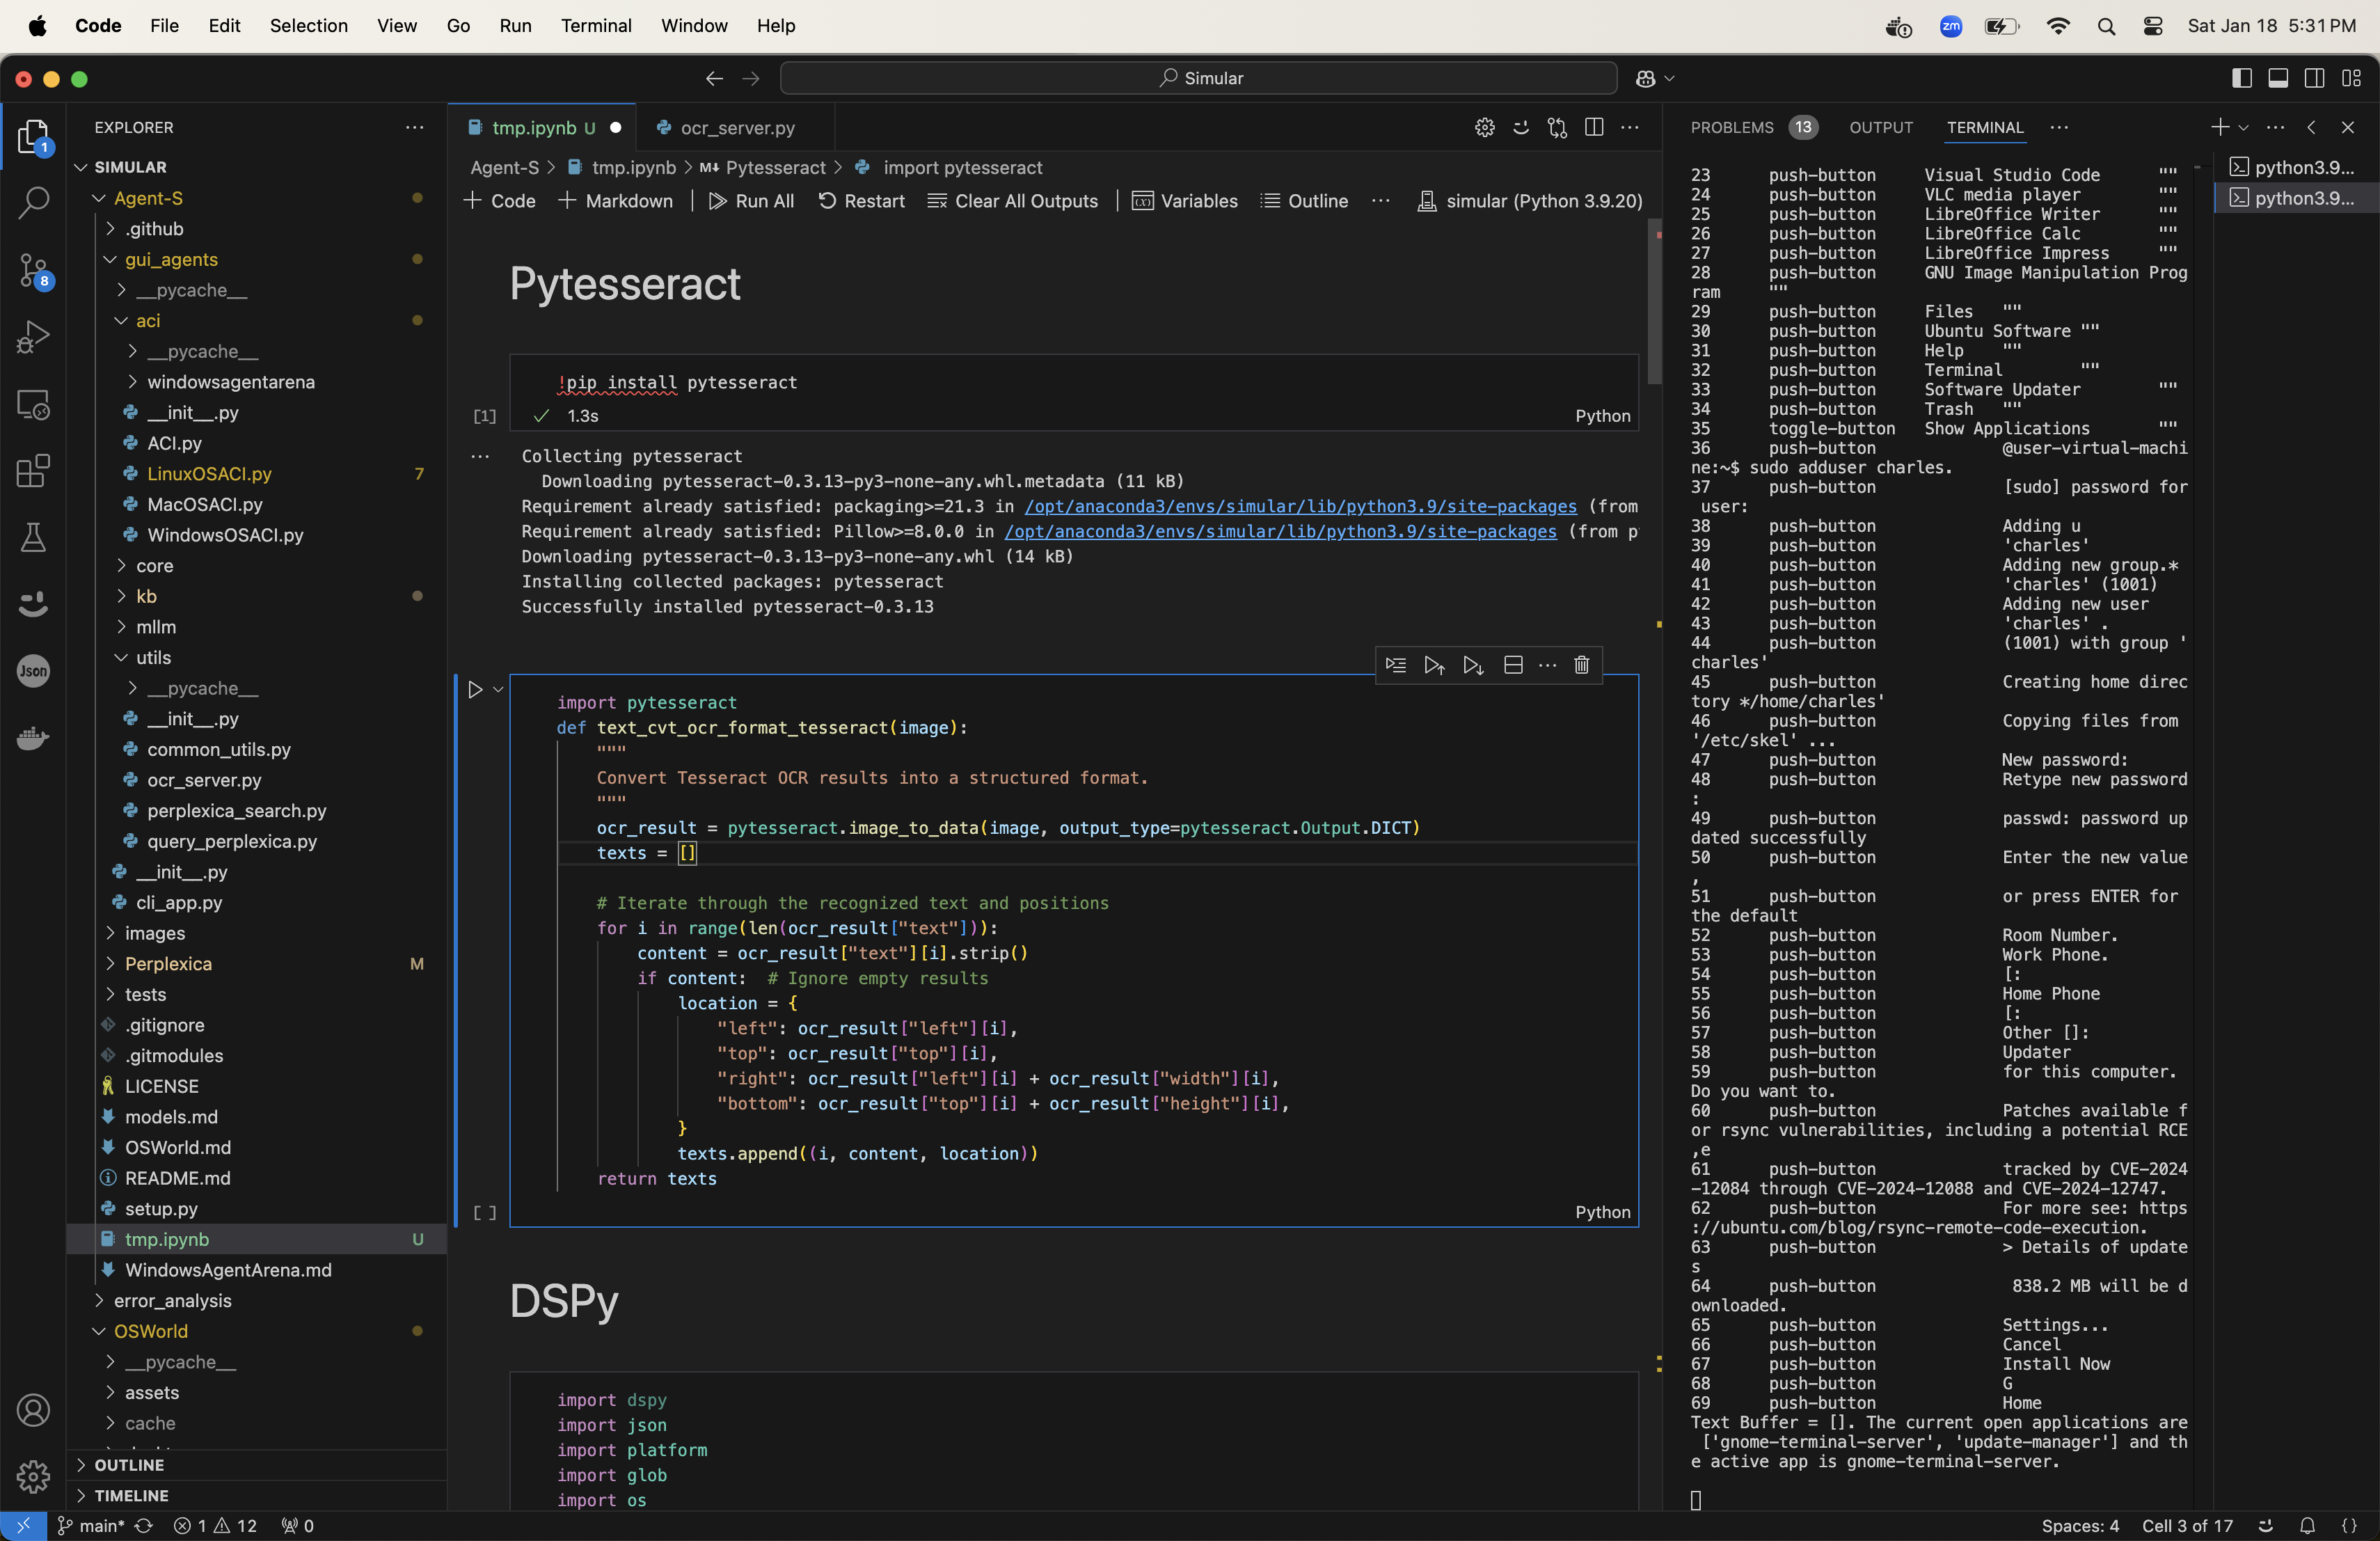

In [3]:
from PIL import Image
import io
import base64

image = Image.open("test_img.png")
image

In [5]:
import pytesseract
ocr_result = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
ocr_result

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

# DSPy

In [2]:
import dspy
import json
import platform
import glob
import os
from PIL import Image
import io
import base64

from gui_agents.core.BaseModule import BaseModule
from gui_agents.core.ProceduralMemory import PROCEDURAL_MEMORY
from gui_agents.aci.LinuxOSACI import LinuxACI

/opt/anaconda3/envs/simular/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
example_id = '7efeb4b1-3d19-4762-b163-63328d66303b'

def get_example_and_traj(example_id):
    with open(f'../OSWorld/evaluation_examples/examples/libreoffice_calc/{example_id}.json', 'r') as f:
        example = json.load(f)

    traj = []
    with open(f'../OSWorld/results/pyautogui/a11y_tree/gpt-4o/libreoffice_calc/{example_id}/traj.jsonl', 'r') as f:
        for line in f:
            traj.append(json.loads(line))

    return example, traj

example, traj = get_example_and_traj(example_id)

In [31]:
example['instruction']

'Fill the Sequence Numbers as "No. #" in the "Seq No." column'

In [9]:
subtasks = []
seen = set()

for step, i in enumerate(traj):
    current_subtask = i['subtask']
    print(f"Step {step}: ", current_subtask, "\t", i['current_subtask'])
    if current_subtask not in seen:
        subtasks.append(current_subtask)
        seen.add(current_subtask)

print(subtasks)


Step 0:  Select cell B2 	 Select cell B2
Step 1:  Select cell B2 	 Select cell B2
Step 2:  Select cell B2 	 Select cell B2
Step 3:  Select cell B2 	 Select cell B2
Step 4:  Select cell B2 	 Select cell B2
Step 5:  Select cell B2 	 Select cell B2
Step 6:  Enter '1' in B2 	 Enter '1' in B2
Step 7:  Select range B2:B21 	 Select range B2:B21
Step 8:  Open Fill Series dialog 	 Open Fill Series dialog
Step 9:  Open Fill Series dialog 	 Open Fill Series dialog
Step 10:  Open Fill Series dialog 	 Open Fill Series dialog
Step 11:  Open Fill Series dialog 	 Open Fill Series dialog
Step 12:  Open Fill Series dialog 	 Open Fill Series dialog
Step 13:  Open Fill Series dialog 	 Open Fill Series dialog
Step 14:  Open Fill Series dialog 	 Open Fill Series dialog
['Select cell B2', "Enter '1' in B2", 'Select range B2:B21', 'Open Fill Series dialog']


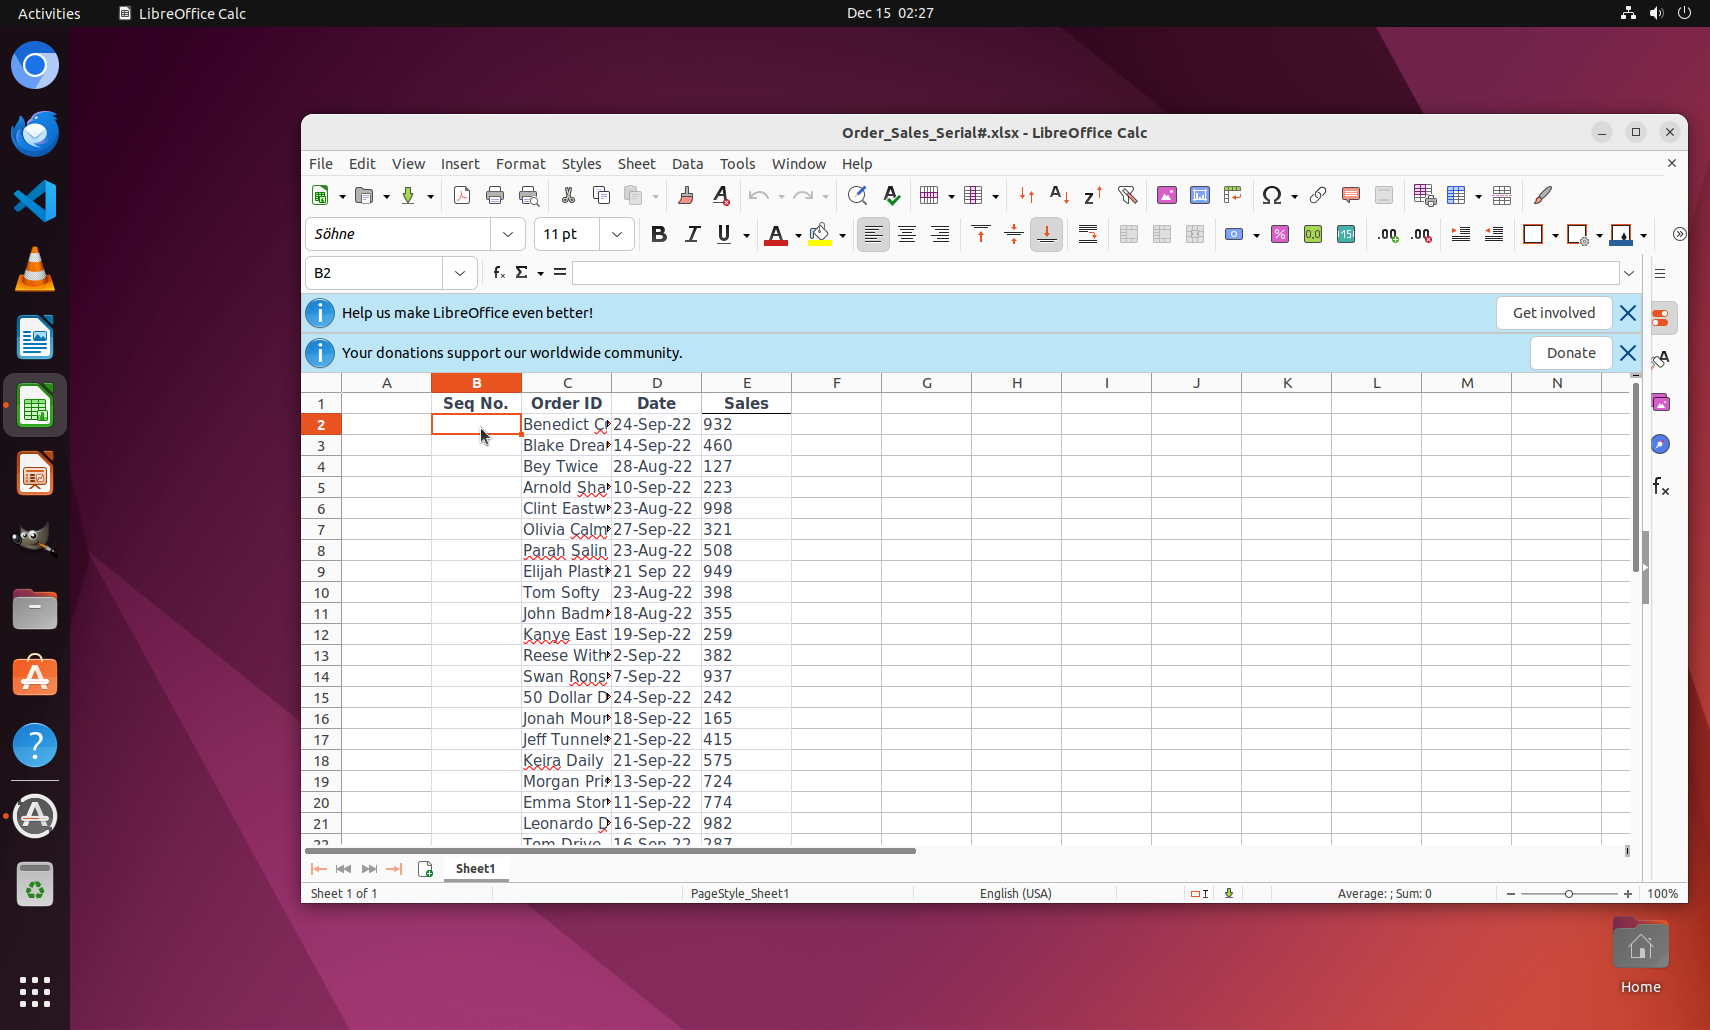

In [30]:
image

In [10]:
turn_count = 1

base_dir = '../OSWorld/results/pyautogui/a11y_tree/gpt-4o/libreoffice_calc'
png_pattern = os.path.join(base_dir, example_id, f'step_{turn_count+1}_*.png')
matching_png_files = glob.glob(png_pattern)

for png_file in matching_png_files:
    print(f"Found PNG file: {png_file}")
    
    image = Image.open(png_file)

    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    screenshot_bytes = buffered.getvalue()

subtask = subtasks[turn_count]
instruction = example['instruction']
future_tasks = subtasks[turn_count+1:]
done_task = subtasks[0:turn_count]
reflection = traj[turn_count]['reflection']
tree_input = traj[turn_count]['linearized_accessibility_tree']
agent_notes = ""
active_apps = "soffice"
top_app = "soffice"
subtask_info = traj[turn_count]['subtask_info']
screenshot = screenshot_bytes

engine_params = {
    "engine_type": "openai",
    "model": "gpt-4o",
}

generator_agent = BaseModule(engine_params=engine_params, platform=platform.system())._create_agent(
    PROCEDURAL_MEMORY.construct_worker_procedural_memory(
        LinuxACI
    ).replace("CURRENT_OS", "Linux")
)

if turn_count == 0:
    generator_agent.add_system_prompt(
    generator_agent.system_prompt.replace(
        "SUBTASK_DESCRIPTION", subtask
    )
    .replace("TASK_DESCRIPTION", instruction)
    .replace("FUTURE_TASKS", ", ".join([f.name for f in future_tasks]))
    .replace("DONE_TASKS", ",".join(d.name for d in done_task))
)

generator_message = (
    (
        f"\nYou may use the reflection on the previous trajectory: {reflection}\n"
        if reflection
        else ""
    )
    + f"Accessibility Tree: {tree_input}\n"
    f"Text Buffer = [{','.join(agent_notes)}]. "
    f"The current open applications are {active_apps} and the active app is {top_app}.\n"
)

if turn_count == 0:
    generator_message += f"Remeber only complete the subtask: {subtask}\n"
    generator_message += f"You can use this extra information for completing the current subtask: {subtask_info}.\n"


generator_agent.add_message(
    generator_message, image_content=screenshot
)

Found PNG file: ../OSWorld/results/pyautogui/a11y_tree/gpt-4o/libreoffice_calc/7efeb4b1-3d19-4762-b163-63328d66303b/step_2_20241214@232736.png


In [ ]:
# system
print(generator_agent.messages[0]['content'][0]['text'])

You are an expert in graphical user interfaces and Python code. You are responsible for executing the current subtask: `SUBTASK_DESCRIPTION` of the larger goal: `TASK_DESCRIPTION`.
IMPORTANT: ** The subtasks: ['DONE_TASKS'] have already been done. The future subtasks ['FUTURE_TASKS'] will be done in the future by me. You must only perform the current subtask: `SUBTASK_DESCRIPTION`. Do not try to do future subtasks. **
You are working in Linux. You must only complete the subtask provided and not the larger goal.
You are provided with:
1. A simplified accessibility tree of the UI at the current time step.
2. A screenshot of the current time step.
3. The history of your previous interactions with the UI.
4. Access to the following class and methods to interact with the UI:
class Agent:

    def click(self, element_id: int, num_clicks: int = 1, button_type: str = 'left', hold_keys: List = []):
    '''Click on the element
        Args:
            element_id:int, ID of the element to click 

In [ ]:
# user
print(generator_agent.messages[1]['content'][0]['text'])


You may use the reflection on the previous trajectory: The trajectory appears to be proceeding as expected, with the task of selecting cell B2 in the "Seq No." column being addressed. Continue with the current plan.
Accessibility Tree: id	tag	name	text
0	toggle-button		""
1	label	Activities	""
2	text		Activities
3	menu	LibreOffice Calc	""
4	label	LibreOffice Calc	""
5	text		LibreOffice Calc
6	menu		""
7	label	Dec 15 02‎∶27	""
8	text		Dec 15 02‎∶27
9	menu	System	""
10	notification		""
11	label	Software Updater	""
12	text		Software Updater
13	push-button		""
14	label	“Software Updater” is ready	""
15	text		“Software Updater” is ready
16	push-button		""
17	push-button		""
18	push-button	Chromium Web Browser	""
19	push-button	Thunderbird Mail	""
20	push-button	Visual Studio Code	""
21	push-button	VLC media player	""
22	push-button	LibreOffice Writer	""
23	push-button	LibreOffice Calc	""
24	push-button	LibreOffice Impress	""
25	push-button	GNU Image Manipulation Program	""
26	push-button	F

In [27]:
from gui_agents.utils.common_utils import call_llm_safe

plan = call_llm_safe(generator_agent)


In [29]:
print(plan)

(Previous action verification)
The previous action of selecting cell B2 in the "Seq No." column appears to have been successful, as indicated by the highlighted cell in the screenshot.

(Screenshot Analysis)
The current state shows LibreOffice Calc open with a spreadsheet titled "Order_Sales_Serial#.xlsx." The cell B2 is highlighted, indicating it is selected. The spreadsheet contains columns labeled "Seq No.," "Order ID," "Date," and "Sales."

(Next Action)
The next step is to enter a sequence number into cell B2.

(Grounded Action)
```python
agent.type(79, text='1', enter=False)
```


In [10]:
import dspy

gpt4o_mini = dspy.LM('openai/gpt-4o-mini', max_tokens=2000)
gpt4o = dspy.LM('openai/gpt-4o', max_tokens=2000)
dspy.configure(lm=gpt4o_mini)  # we'll use gpt-4o-mini as the default LM, unless otherwise specified

In [8]:
cot = dspy.ChainOfThought("context -> action")

In [ ]:
optimizer = dspy.MIPROv2(metric=metric, auto="light", num_threads=16, prompt_model=gpt4o)

config = dict(max_bootstrapped_demos=1, max_labeled_demos=0, minibatch_size=40)
optimized_4o = optimizer.compile(cot, trainset=trainset, **config, requires_permission_to_run=False)